In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from scipy.ndimage import gaussian_filter
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import probplot
from pyod.models.mad import MAD
# from google.colab import drive
from statsmodels.tsa.arima_model import  ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
import joblib
from sklearn.preprocessing import OneHotEncoder
import pickle 
import os
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from prophet import Prophet


### Read Data

In [ ]:
df = pd.read_csv('/kaggle/input/rossman-retail-stores/rossman.csv')
df

,Unnamed: 0,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,WeekOfYear,DayOfYear
0,0,1,5,7/31/2015,5263,555,1,1,0,1,...,9,2008,0,0,0,0,2015,7,31,212
1,1,2,5,7/31/2015,6064,625,1,1,0,1,...,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",2015,7,31,212
2,2,3,5,7/31/2015,8314,821,1,1,0,1,...,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",2015,7,31,212
3,3,4,5,7/31/2015,13995,1498,1,1,0,1,...,9,2009,0,0,0,0,2015,7,31,212
4,4,5,5,7/31/2015,4822,559,1,1,0,1,...,4,2015,0,0,0,0,2015,7,31,212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1017204,1111,2,1/1/2013,0,0,0,0,1,1,...,6,2014,1,31,2013,"Jan,Apr,Jul,Oct",2013,1,1,1
1017205,1017205,1112,2,1/1/2013,0,0,0,0,1,1,...,4,2006,0,0,0,0,2013,1,1,1
1017206,1017206,1113,2,1/1/2013,0,0,0,0,1,1,...,9,2013,0,0,0,0,2013,1,1,1
1017207,1017207,1114,2,1/1/2013,0,0,0,0,1,1,...,9,2013,0,0,0,0,2013,1,1,1


Store - a unique Id for each store

Sales - the turnover for any given day (this is what you are predicting)

Customers - the number of customers on a given day

Open - an indicator for whether the store was open: 0 = closed, 1 = open

StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

StoreType - differentiates between 4 different store models: a, b, c, d

Assortment - describes an assortment level: a = basic, b = extra, c = extended

CompetitionDistance - distance in meters to the nearest competitor store

CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

Promo - indicates whether a store is running a promo on that day

Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

### Check the stores in dataset to know how many stores

In [18]:
all_stores=[i for i in df['Store'].unique()]
# all_stores

In [19]:
df = df.sort_index()

### remove the unnamed column

In [20]:
df.drop(columns='Unnamed: 0',inplace=True)

<!-- Store - a unique Id for each store

Sales - the turnover for any given day (this is what you are predicting)

Customers - the number of customers on a given day

Open - an indicator for whether the store was open: 0 = closed, 1 = open

StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

StoreType - differentiates between 4 different store models: a, b, c, d

Assortment - describes an assortment level: a = basic, b = extra, c = extended

CompetitionDistance - distance in meters to the nearest competitor store

CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

Promo - indicates whether a store is running a promo on that day

Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store -->


In [21]:
df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,WeekOfYear,DayOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,9.0,2008.0,0,0.0,0.0,0,2015,7,31,212
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,212
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,212
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,9.0,2009.0,0,0.0,0.0,0,2015,7,31,212
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,4.0,2015.0,0,0.0,0.0,0,2015,7,31,212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,1,1,a,...,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,1
1017205,1112,2,2013-01-01,0,0,0,0,1,1,c,...,4.0,2006.0,0,0.0,0.0,0,2013,1,1,1
1017206,1113,2,2013-01-01,0,0,0,0,1,1,a,...,9.0,2013.0,0,0.0,0.0,0,2013,1,1,1
1017207,1114,2,2013-01-01,0,0,0,0,1,1,a,...,9.0,2013.0,0,0.0,0.0,0,2013,1,1,1


In [10]:
df['StateHoliday'].value_counts()

StateHoliday
0    986159
1     31050
Name: count, dtype: int64

In [11]:
df.shape

(1017209, 22)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 22 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  int64  
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1017209 non-null  float64
 12  CompetitionOpenSinceMonth  1017209 non-null  float64
 13  CompetitionO

In [12]:
df.isnull().sum()

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
Year                         0
Month                        0
WeekOfYear                   0
DayOfYear                    0
dtype: int64

##### change the Date to datetime type

In [13]:
df['Date']=pd.to_datetime(df['Date'])

In [ ]:
df.describe()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,Month,WeekOfYear,DayOfYear
count,1.017209e+06,1.017209e+06,1017209,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,2014-04-11 01:30:42.846061824,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,3.052470e-02,1.786467e-01,5.422021e+03,7.787777e+00,2.010060e+03,5.005638e-01,1.164767e+01,1.007011e+03,2.013832e+03,5.846762e+00,2.361551e+01,1.622764e+02
min,1.000000e+00,1.000000e+00,2013-01-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+01,1.000000e+00,1.900000e+03,0.000000e+00,0.000000e+00,0.000000e+00,2.013000e+03,1.000000e+00,1.000000e+00,1.000000e+00
25%,2.800000e+02,2.000000e+00,2013-08-17 00:00:00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.100000e+02,6.000000e+00,2.008000e+03,0.000000e+00,0.000000e+00,0.000000e+00,2.013000e+03,3.000000e+00,1.100000e+01,7.700000e+01
50%,5.580000e+02,4.000000e+00,2014-04-02 00:00:00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.325000e+03,9.000000e+00,2.012000e+03,1.000000e+00,1.000000e+00,2.009000e+03,2.014000e+03,6.000000e+00,2.200000e+01,1.530000e+02
75%,8.380000e+02,6.000000e+00,2014-12-12 00:00:00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,6.880000e+03,9.000000e+00,2.013000e+03,1.000000e+00,2.200000e+01,2.012000e+03,2.014000e+03,8.000000e+00,3.500000e+01,2.410000e+02
max,1.115000e+03,7.000000e+00,2015-07-31 00:00:00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,7.586000e+04,1.200000e+01,2.015000e+03,1.000000e+00,5.000000e+01,2.015000e+03,2.015000e+03,1.200000e+01,5.200000e+01,3.650000e+02
std,3.219087e+02,1.997391e+00,NaN,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,1.720261e-01,3.830564e-01,7.706918e+03,2.778755e+00,5.340757e+00,4.999999e-01,1.532393e+01,1.005877e+03,7.773960e-01,3.326097e+00,1.443338e+01,1.016162e+02


#### the mean and median is not far away from each other this means their is not many outliers

In [ ]:
df['Store'].nunique()

1115

In [ ]:
df['Store'].value_counts()

,count
Store,
1115,942
1,942
2,942
3,942
4,942
...,...
32,758
36,758
41,758


In [ ]:
df.duplicated().sum()

np.int64(0)

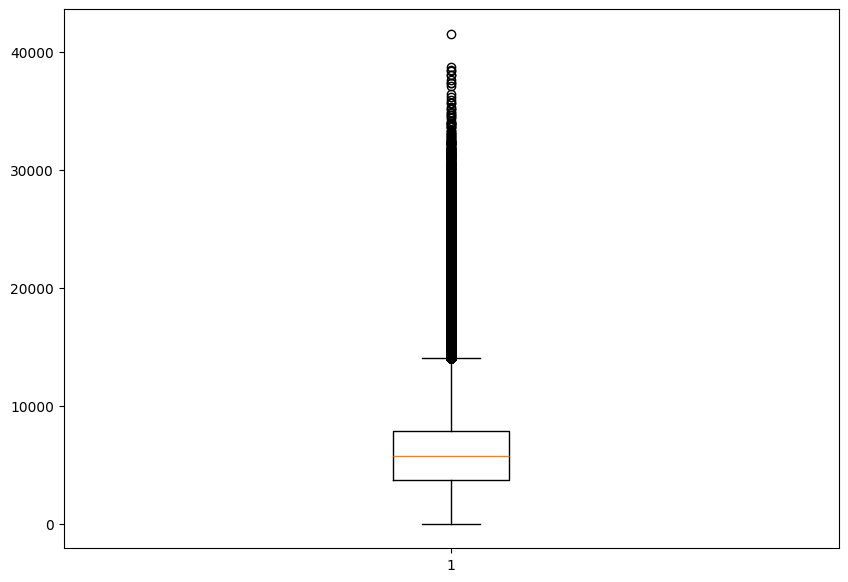

In [ ]:
fig = plt.figure(figsize =(10, 7))

# Creating plot
plt.boxplot(df['Sales']);

Text(0, 0.5, 'Frequency')

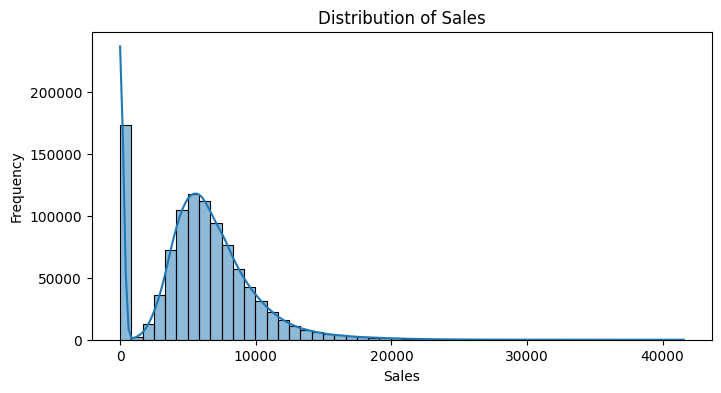

In [ ]:
# peform histogram to see the spread of the data
plt.figure(figsize=(8, 4))
sns.histplot(df['Sales'], bins=50, kde=True)
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')

Text(0.5, 1.0, 'Sales per Store')

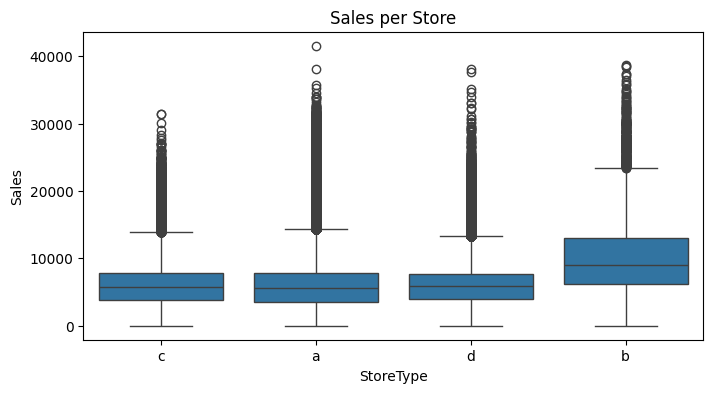

In [ ]:
plt.subplots(figsize=(8, 4))
sns.boxplot(data=df, x='StoreType', y='Sales')
plt.title('Sales per Store')


### Try the IQR first

In [ ]:
# q1=np.quantile(df['Sales'],0.25)
# q3=np.quantile(df['Sales'],0.75)
# iqr = q3 - q1
# lower_limit = q1 - 1.5 * iqr
# upper_limit = q3 + 1.5 * iqr
# df['value_check']=np.where(((df['Sales'] < lower_limit) | (df['Sales'] > upper_limit)),1,0)

In [ ]:
# df['value_check'].value_counts()

### MAD 

In [25]:
# Column needs to be checked
data = df['Sales']
data = data.values.reshape(-1,1)

# Initiate the Model (choose 3 as it is the common used value in MAD)
mad_detector = MAD(threshold = 3)

# fitting the model
mad_detector.fit(data)

df['MAD_Library_Label']= mad_detector.labels_

In [26]:
df['MAD_Library_Label'].value_counts()

MAD_Library_Label
0    997088
1     20121
Name: count, dtype: int64

In [27]:
# empty dictionary
Store_median = {}

# Calculate the median for each store
for store in df['Store'].unique():
    Store_median[store] = np.median(df[(df['Store'] == store) & (df['MAD_Library_Label'] == 0)]['Store'])

# Store_median


In [28]:
# Define the median_store function imputation
def median_store(row:pd.Series)->float:
    if row['MAD_Library_Label'] == 0:
        return row['Sales']  # If MAD_Library_Label is 0, keep the original value
    else:
        store = row['Store']
        return Store_median[store]  # If MAD_Library_Label is not 0, use the median from store_median


In [29]:
# Apply the median_store function to create the new column
df['Sales'] = df.apply(median_store, axis=1)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Frequency')

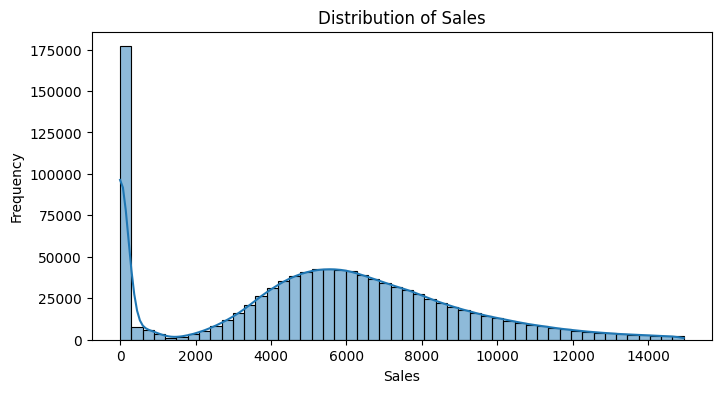

In [30]:
# peform histogram to see the spread of the data
plt.figure(figsize=(8, 4))
sns.histplot(df['Sales'], bins=50, kde=True)
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')

In [ ]:
fig = plt.figure(figsize =(10, 7))

# Creating plot
plt.boxplot(df['Sales']);

## Feature engineering

In [ ]:
df['SalePerCustomer'] = df['Sales']/df['Customers']
df


## EDA

##### Line chart for all sales in three years together

Text(0.5, 1.0, 'sales')

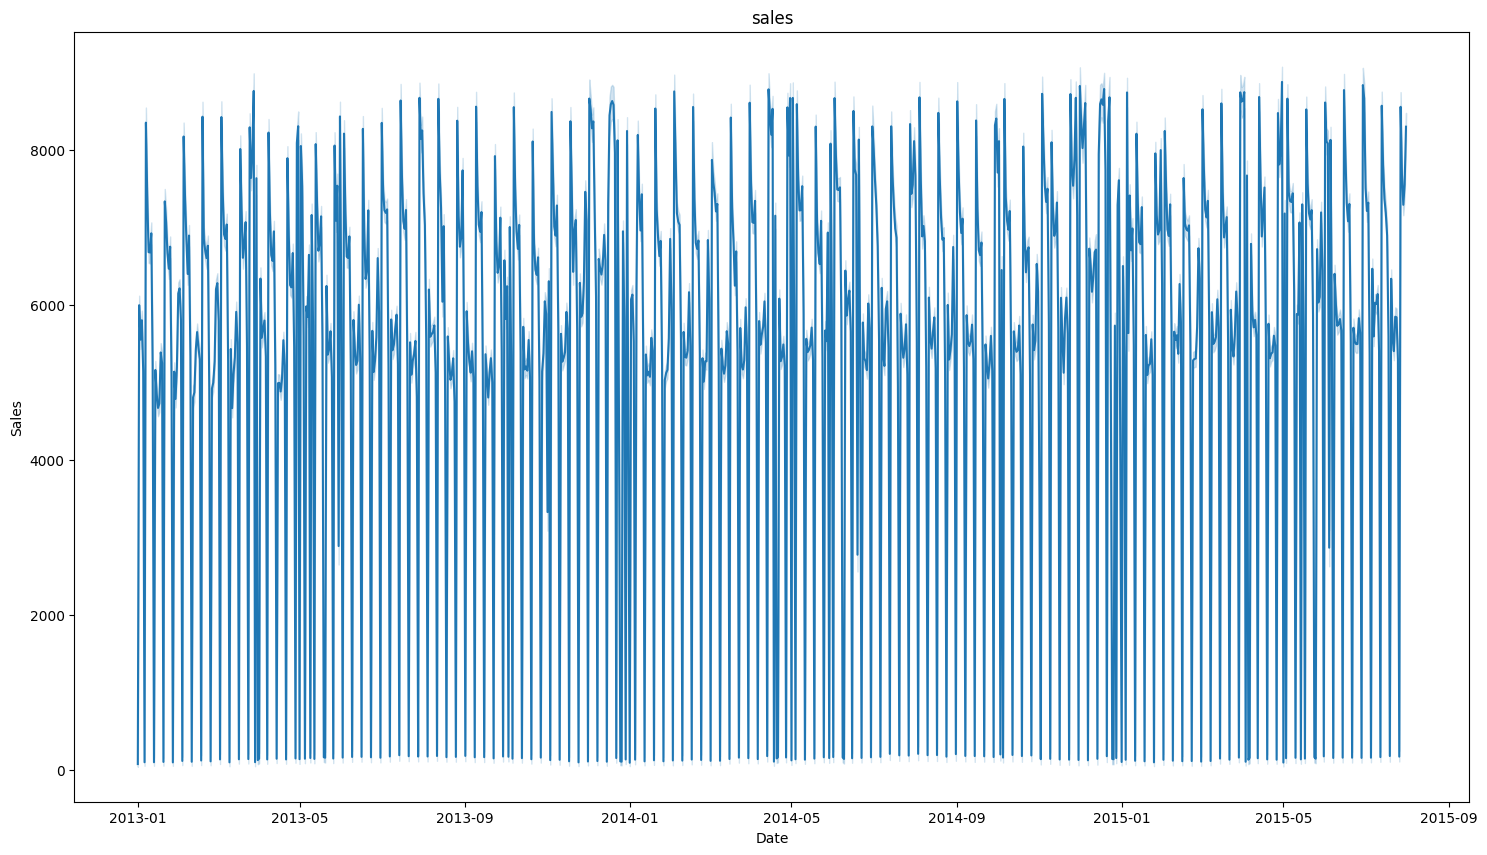

In [ ]:
plt.figure(figsize=(18,10))
sns.lineplot(data=df,x='Date',y='Sales')
plt.title('sales')

In [ ]:
df_2013 = df[(df['Date'].dt.year == 2013)]
df_2014 = df[(df['Date'].dt.year == 2014)]
df_2015 = df[(df['Date'].dt.year == 2015)]

In [ ]:
# Extract month
df_2013['Month'] = df_2013['Date'].dt.month
df_2014['Month'] = df_2014['Date'].dt.month
df_2015['Month'] = df_2015['Date'].dt.month

# Group by month and calculate mean
monthly_sales_2013 = df_2013.groupby('Month')['Sales'].mean()
monthly_sales_2014 = df_2014.groupby('Month')['Sales'].mean()
monthly_sales_2015 = df_2015.groupby('Month')['Sales'].mean()

<ipython-input-31-41d146e47ffb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2013['Month'] = df_2013['Date'].dt.month
<ipython-input-31-41d146e47ffb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2014['Month'] = df_2014['Date'].dt.month
<ipython-input-31-41d146e47ffb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

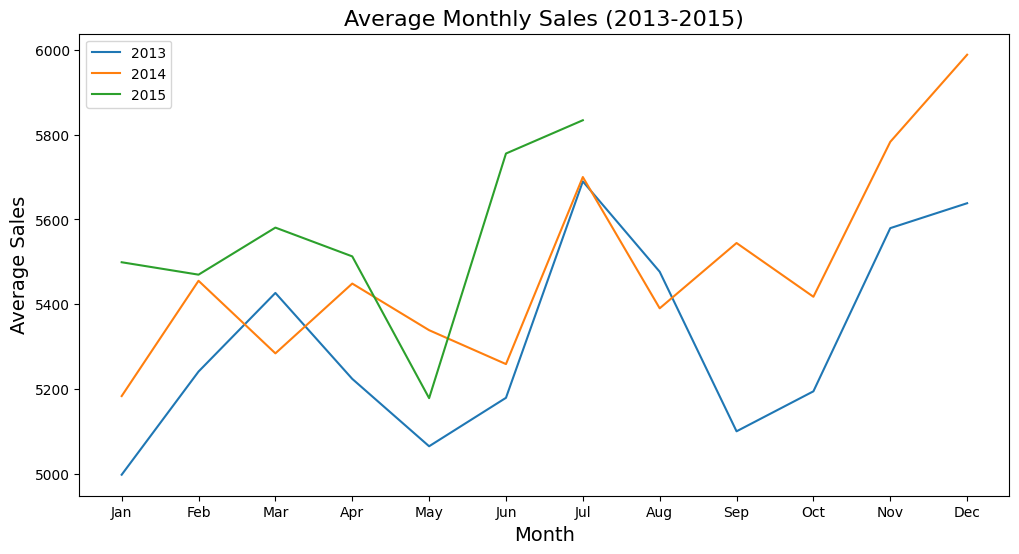

In [ ]:
plt.figure(figsize=(12, 6))

sns.lineplot(x=monthly_sales_2013.index, y=monthly_sales_2013.values, label='2013')
sns.lineplot(x=monthly_sales_2014.index, y=monthly_sales_2014.values, label='2014')
sns.lineplot(x=monthly_sales_2015.index, y=monthly_sales_2015.values, label='2015')

plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Average Monthly Sales (2013-2015)', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Average Sales', fontsize=14)
plt.legend()

### Days of week

<Axes: xlabel='DayOfWeek', ylabel='count'>

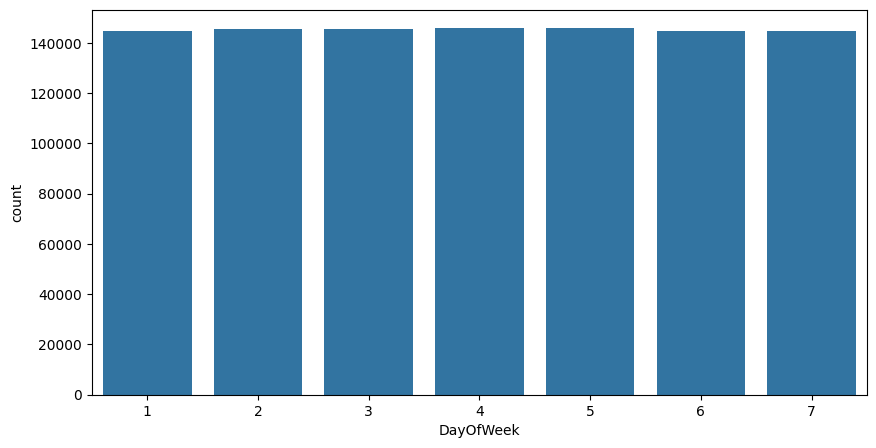

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data=df,x='DayOfWeek')

<Axes: xlabel='Open', ylabel='count'>

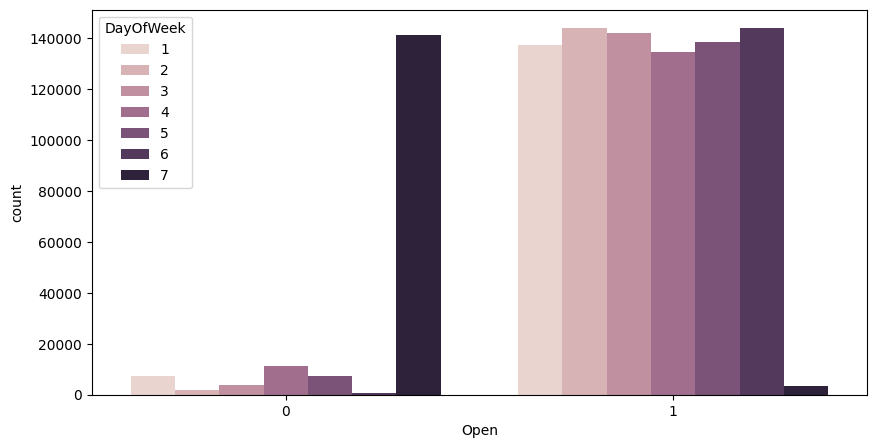

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data=df,x='Open',hue='DayOfWeek')


### sales on days of week

<ipython-input-35-280f420743bc>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='DayOfWeek', y='Sales', estimator=np.mean, ci=None)


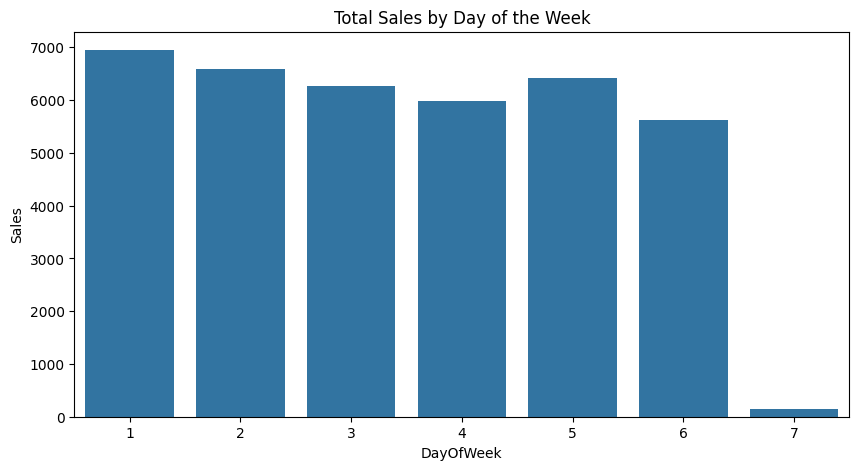

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x='DayOfWeek', y='Sales', estimator=np.mean, ci=None)
plt.title('Total Sales by Day of the Week');

### No. of days when store was opened but zero sales

In [ ]:
len(df[(df.Open == 1) & (df.Sales == 0)])

54

In [ ]:
df_open_zero=df[(df.Open == 1) & (df.Sales == 0)]

<Axes: xlabel='StateHoliday', ylabel='count'>

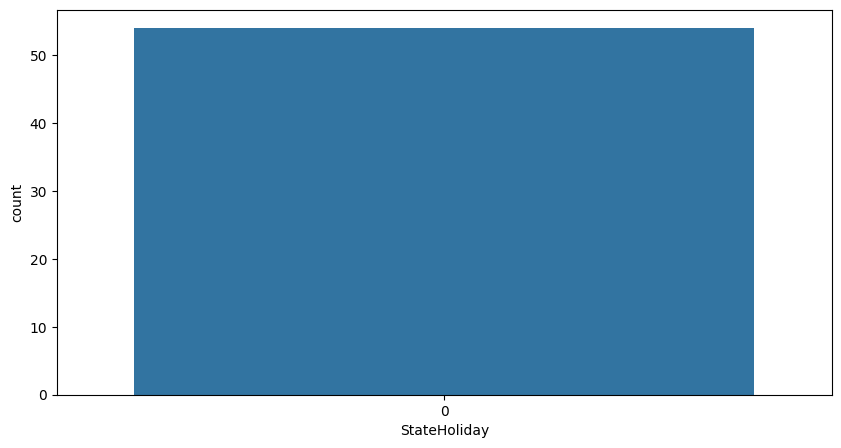

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data=df_open_zero,x='StateHoliday')

<Axes: xlabel='SchoolHoliday', ylabel='count'>

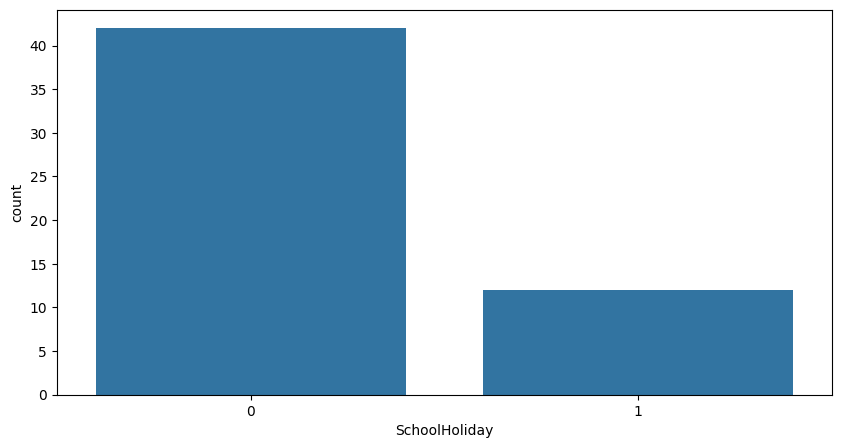

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data=df_open_zero,x='SchoolHoliday')

<Axes: xlabel='DayOfWeek', ylabel='count'>

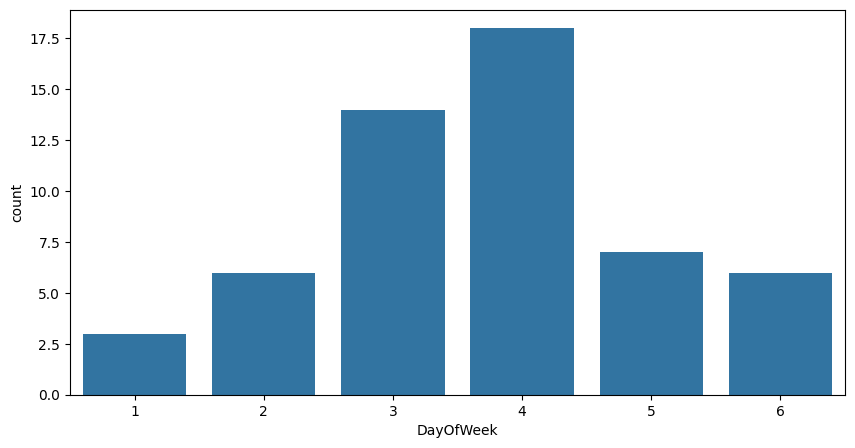

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data=df_open_zero,x='DayOfWeek')

<Axes: xlabel='Month', ylabel='count'>

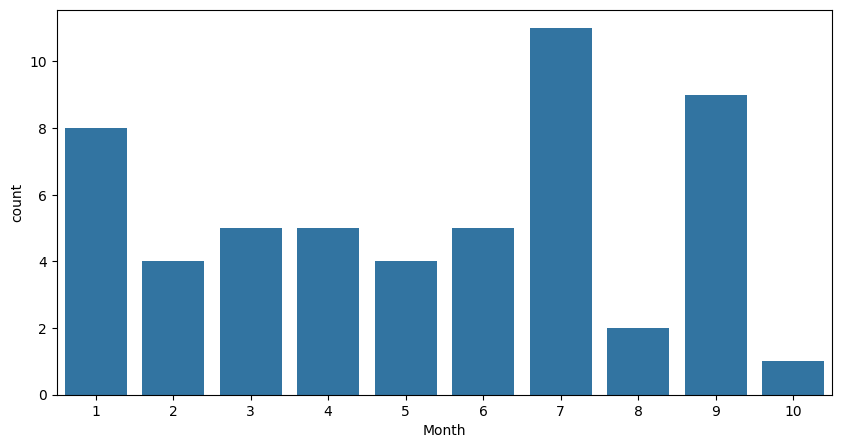

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data=df_open_zero,x='Month')

In [ ]:
df_numerics_only = df.select_dtypes(include=np.number)


## Correlation analysis

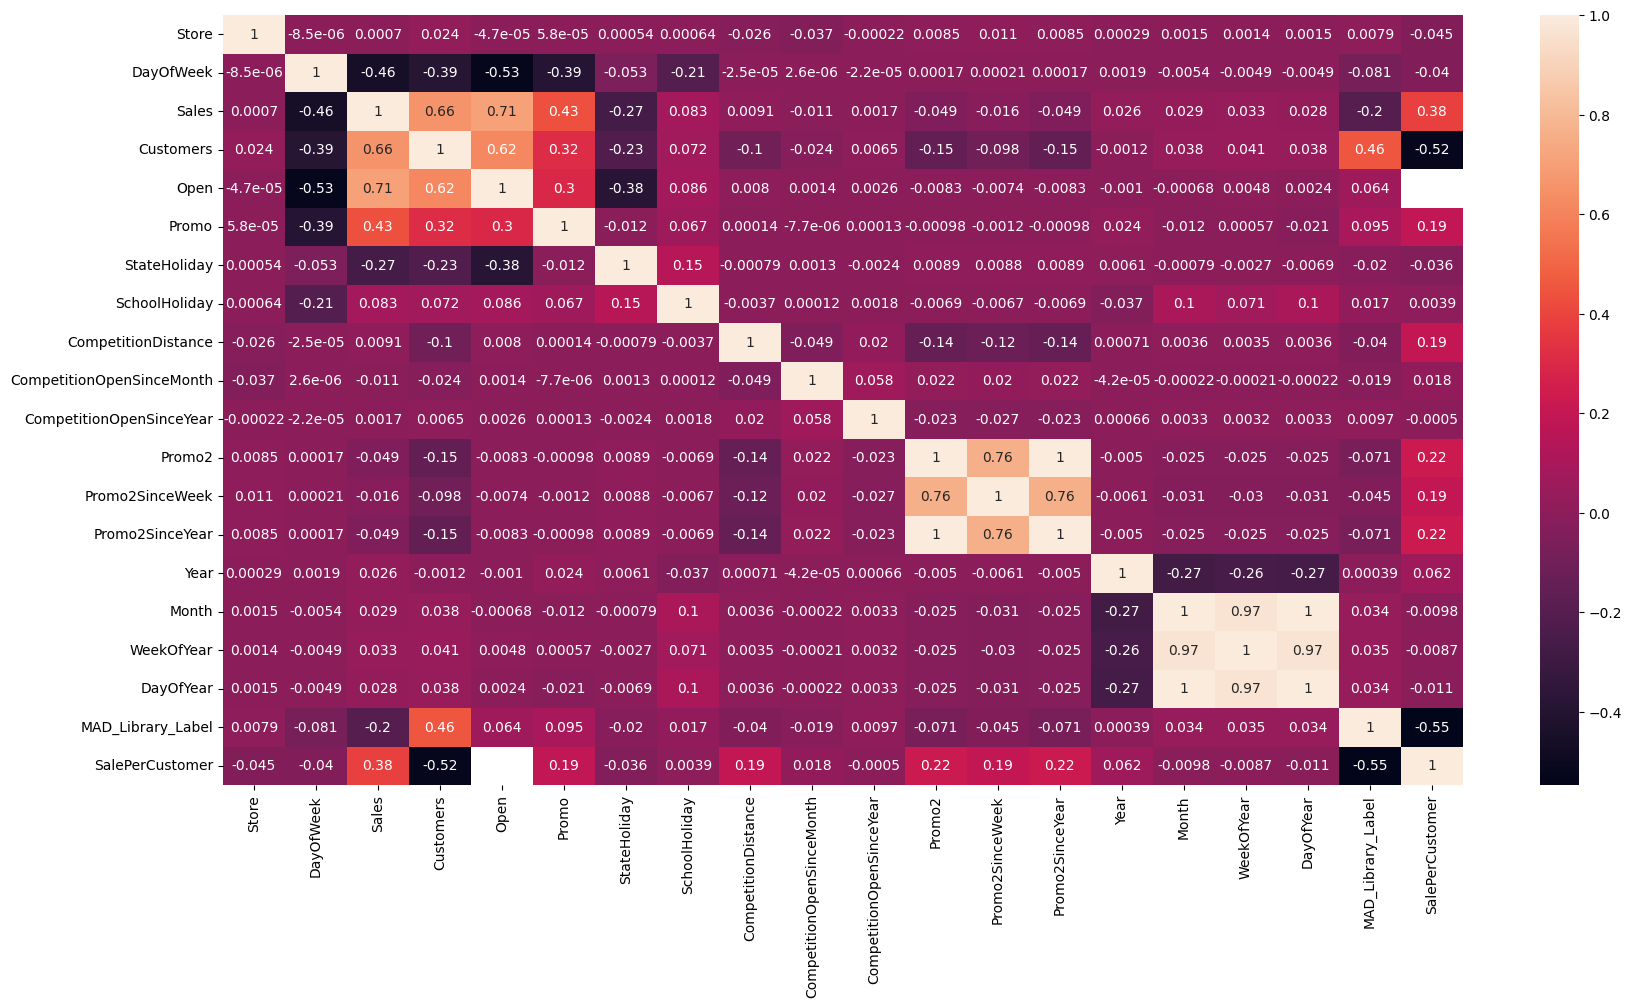

In [ ]:
# Correlation
plt.figure(figsize = (20, 10))
sns.heatmap(df_numerics_only.corr(), annot = True);

Text(0.5, 0, 'Customers')

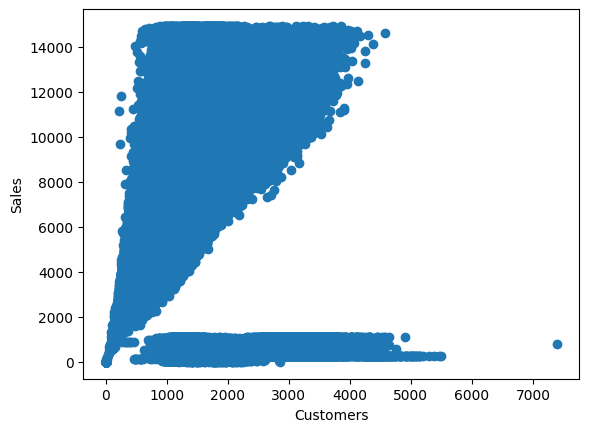

In [ ]:
plt.scatter(data=df,y='Sales',x='Customers')
plt.ylabel('Sales')
plt.xlabel('Customers')

In [ ]:
# Apply log transformation to selected numerical columns
columns_to_log = ['Sales', 'Customers', 'CompetitionDistance']
df[columns_to_log] = df[columns_to_log].apply(lambda x: np.log1p(x))

array([[<Axes: title={'center': 'Sales'}>,
        <Axes: title={'center': 'Customers'}>],
       [<Axes: title={'center': 'CompetitionDistance'}>, <Axes: >]],
      dtype=object)

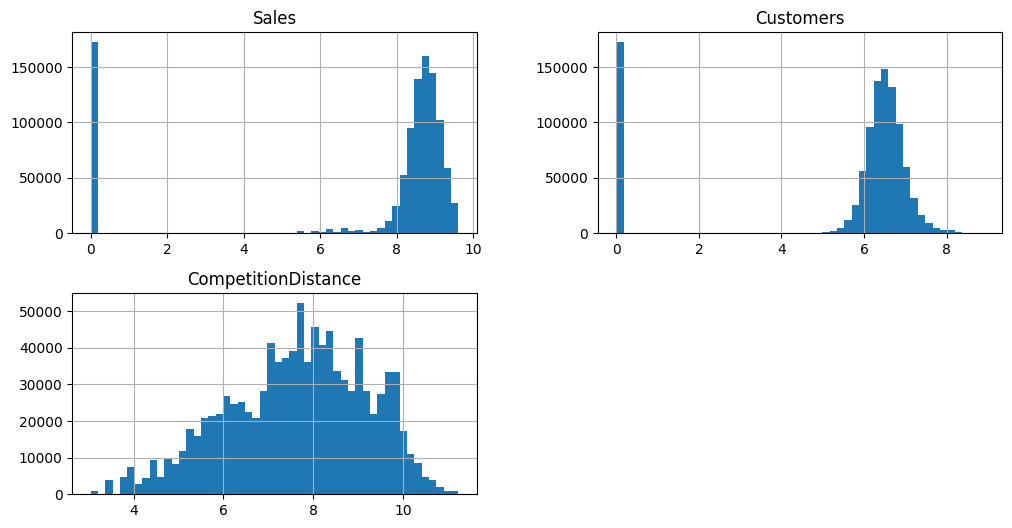

In [ ]:
# Check transformation
df[columns_to_log].hist(figsize=(12, 6), bins=50)

#### we can see as the customers increas the sales increase (positive correlation) , also when there is a promo the sales and number of custimers increase (positive correlation)

## Missing Date in Sores

In [31]:
start_date = df['Date'].min()
start_date

'2013-01-01'

In [32]:
end_date = df['Date'].max()
end_date

'2015-07-31'

In [33]:
df['Date'] = pd.to_datetime(df['Date'])


In [34]:
full_dates = pd.date_range(start='2013-01-01', end='2015-07-31')


In [35]:
stores = df['Store'].unique()


In [36]:
full_index = pd.MultiIndex.from_product([stores, full_dates], names=['Store', 'Date'])
full_df = pd.DataFrame(index=full_index).reset_index()

In [37]:
merged = pd.merge(full_df, df, on=['Store', 'Date'], how='left', indicator=True)

# Step 6: Filter the missing ones
missing = merged[merged['_merge'] == 'left_only']

In [ ]:
if missing.empty:
    print("All stores have all dates from 2013-01-01 to 2015-07-31.")
else:
    print("Some store-date combinations are missing.")
    print(missing[['Store', 'Date']])

❌ Some store-date combinations are missing.
         Store       Date
11850       13 2014-07-01
11851       13 2014-07-02
11852       13 2014-07-03
11853       13 2014-07-04
11854       13 2014-07-05
...        ...        ...
1044461   1109 2014-12-27
1044462   1109 2014-12-28
1044463   1109 2014-12-29
1044464   1109 2014-12-30
1044465   1109 2014-12-31

[33121 rows x 2 columns]


In [39]:
missing_list = missing['Store'].unique().tolist()
# missing_list

In [40]:
df_cleaned = df[~df['Store'].isin(missing_list)].copy()
df_cleaned

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,WeekOfYear,DayOfYear,MAD_Library_Label
0,1,5,2015-07-31,5263.0,555,1,1,0,1,c,...,2008.0,0,0.0,0.0,0,2015,7,31,212,0
1,2,5,2015-07-31,6064.0,625,1,1,0,1,a,...,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,212,0
2,3,5,2015-07-31,8314.0,821,1,1,0,1,a,...,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,212,0
3,4,5,2015-07-31,13995.0,1498,1,1,0,1,c,...,2009.0,0,0.0,0.0,0,2015,7,31,212,0
4,5,5,2015-07-31,4822.0,559,1,1,0,1,a,...,2015.0,0,0.0,0.0,0,2015,7,31,212,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0.0,0,0,0,1,1,a,...,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,1,0
1017205,1112,2,2013-01-01,0.0,0,0,0,1,1,c,...,2006.0,0,0.0,0.0,0,2013,1,1,1,0
1017206,1113,2,2013-01-01,0.0,0,0,0,1,1,a,...,2013.0,0,0.0,0.0,0,2013,1,1,1,0
1017207,1114,2,2013-01-01,0.0,0,0,0,1,1,a,...,2013.0,0,0.0,0.0,0,2013,1,1,1,0


In [41]:
df_cleaned['Store'].value_counts()

Store
1       942
756     942
742     942
743     942
745     942
       ... 
377     942
378     942
379     942
380     942
1115    942
Name: count, Length: 934, dtype: int64

In [ ]:
#renumberi the stores
df_cleaned['Store'] = pd.factorize(df_cleaned['Store'])[0] + 1
df_cleaned

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,WeekOfYear,DayOfYear,MAD_Library_Label
0,1,5,2015-07-31,5263.0,555,1,1,0,1,c,...,2008.0,0,0.0,0.0,0,2015,7,31,212,0
1,2,5,2015-07-31,6064.0,625,1,1,0,1,a,...,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,212,0
2,3,5,2015-07-31,8314.0,821,1,1,0,1,a,...,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,212,0
3,4,5,2015-07-31,13995.0,1498,1,1,0,1,c,...,2009.0,0,0.0,0.0,0,2015,7,31,212,0
4,5,5,2015-07-31,4822.0,559,1,1,0,1,a,...,2015.0,0,0.0,0.0,0,2015,7,31,212,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,930,2,2013-01-01,0.0,0,0,0,1,1,a,...,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,1,0
1017205,931,2,2013-01-01,0.0,0,0,0,1,1,c,...,2006.0,0,0.0,0.0,0,2013,1,1,1,0
1017206,932,2,2013-01-01,0.0,0,0,0,1,1,a,...,2013.0,0,0.0,0.0,0,2013,1,1,1,0
1017207,933,2,2013-01-01,0.0,0,0,0,1,1,a,...,2013.0,0,0.0,0.0,0,2013,1,1,1,0


In [43]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 879828 entries, 0 to 1017208
Data columns (total 23 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      879828 non-null  int64         
 1   DayOfWeek                  879828 non-null  int64         
 2   Date                       879828 non-null  datetime64[ns]
 3   Sales                      879828 non-null  float64       
 4   Customers                  879828 non-null  int64         
 5   Open                       879828 non-null  int64         
 6   Promo                      879828 non-null  int64         
 7   StateHoliday               879828 non-null  int64         
 8   SchoolHoliday              879828 non-null  int64         
 9   StoreType                  879828 non-null  object        
 10  Assortment                 879828 non-null  object        
 11  CompetitionDistance        879828 non-null  float64     

### Drop the Store Column for the label encoding and the mad_library_label before the label encoding

In [ ]:
df_cleaned.drop(columns=['Store','MAD_Library_Label'], inplace=True)

In [45]:
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date']) 

## Label Encoding

In [ ]:
# Select categorical columns
categorical_columns = df_cleaned.select_dtypes(include=['object']).columns.tolist()

# One-hot encode
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
one_hot_encoded = encoder.fit_transform(df_cleaned[categorical_columns])
#Save the encoder
joblib.dump(encoder, '/kaggle/working/encoder.pkl')

# Create one-hot encoded DataFrame and reset index
one_hot_df = pd.DataFrame(one_hot_encoded, 
                          columns=encoder.get_feature_names_out(categorical_columns))
one_hot_df.index = df_cleaned.index  # important to preserve original row order

# Concatenate and drop original categorical columns
df_encoded = pd.concat([df_cleaned.drop(columns=categorical_columns), one_hot_df], axis=1)

df_encoded


,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,...,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec"
0,5,2015-07-31,5263.0,555,1,1,0,1,1270.0,9.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,5,2015-07-31,6064.0,625,1,1,0,1,570.0,11.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,5,2015-07-31,8314.0,821,1,1,0,1,14130.0,12.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,5,2015-07-31,13995.0,1498,1,1,0,1,620.0,9.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,5,2015-07-31,4822.0,559,1,1,0,1,29910.0,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,2,2013-01-01,0.0,0,0,0,1,1,1900.0,6.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1017205,2,2013-01-01,0.0,0,0,0,1,1,1880.0,4.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1017206,2,2013-01-01,0.0,0,0,0,1,1,9260.0,9.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1017207,2,2013-01-01,0.0,0,0,0,1,1,870.0,9.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [118]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 879828 entries, 0 to 1017208
Data columns (total 29 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   DayOfWeek                       879828 non-null  int64         
 1   Date                            879828 non-null  datetime64[ns]
 2   Sales                           879828 non-null  float64       
 3   Customers                       879828 non-null  int64         
 4   Open                            879828 non-null  int64         
 5   Promo                           879828 non-null  int64         
 6   StateHoliday                    879828 non-null  int64         
 7   SchoolHoliday                   879828 non-null  int64         
 8   CompetitionDistance             879828 non-null  float64       
 9   CompetitionOpenSinceMonth       879828 non-null  float64       
 10  CompetitionOpenSinceYear        879828 non-null  float64    

In [ ]:
# Define your model and the path where you want to save it
model = encoder  # R
save_path = os.path.join("/kaggle/working", "encoder.pkl")  # Update with your desired path

# Save the model
with open(save_path, 'wb') as file:
    pickle.dump(model, file)

print(f"Model saved successfully at {save_path}")

Model saved successfully at /kaggle/working/encoder.pkl
Model loaded successfully!


In [ ]:
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:", result[4])
    if result[1] <= 0.05:
        print("Reject null hypothesis, the series is stationary")
    else:
        print("Fail to reject null hypothesis, the series is not stationary")

In [ ]:
df_sample = df_cleaned.sample(5000, random_state=42)  # Adjust the sample size as needed
adf_test(df_sample['Sales'])

ADF Statistic: -69.99744877528285
p-value: 0.0
Critical Values: {'1%': -3.431658793968827, '5%': -2.862118345383404, '10%': -2.567077853953267}
Reject null hypothesis, the series is stationary


<Figure size 1200x500 with 0 Axes>

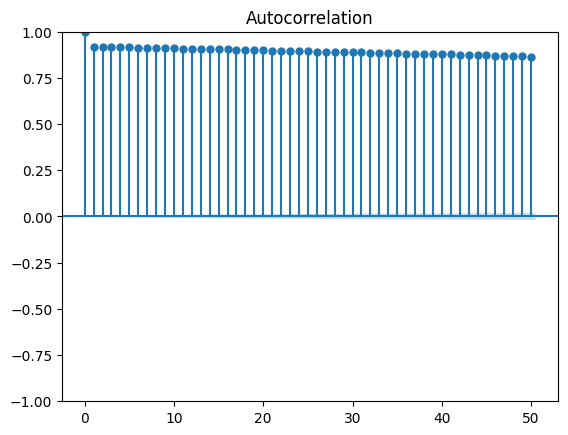

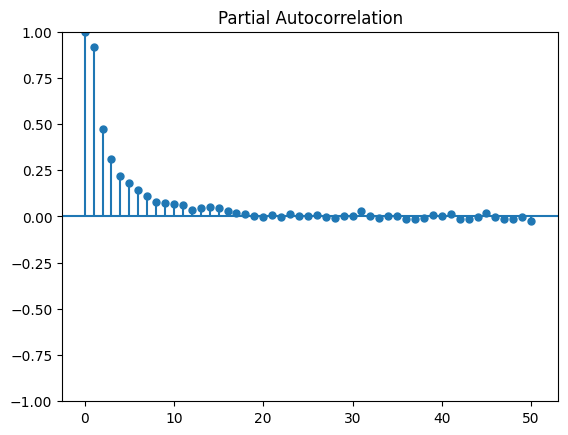

In [ ]:
plt.figure(figsize=(12,5))
plot_acf(df_cleaned['Sales'], lags=50)  # Autocorrelation
plot_pacf(df_cleaned['Sales'], lags=50)  # Partial autocorrelation
plt.show()

In [ ]:
# Apply seasonal differencing (for weekly seasonality)
y_diff = df_cleaned['Sales'] - df_cleaned['Sales'].shift(40)
y_diff = y_diff.dropna()


### Fast Fourier Transform to know seasonality

In [ ]:
# Apply FFT (Fast Fourier Transform)
fft = np.fft.fft(df_cleaned['Sales'] - np.mean(df_cleaned['Sales']))
frequencies = np.fft.fftfreq(len(fft))

# Get peak frequency (ignoring 0)
peak_freq = abs(frequencies[np.argmax(np.abs(fft[1:])) + 1])
seasonal_period = int(round(1 / peak_freq))
print("Detected seasonal period:", seasonal_period)


Detected seasonal period: 3271


### Split to train and test data

In [ ]:
# Train: 2013-01-01 to 2015-05-01
train_df = df_encoded[(df_encoded['Date'] >= pd.to_datetime('2013-01-01')) & 
                      (df_encoded['Date'] <= pd.to_datetime('2015-05-01'))]

# Test: 2015-05-02 to 2015-07-31
test_df = df_encoded[(df_encoded['Date'] >= pd.to_datetime('2015-05-02')) & 
                     (df_encoded['Date'] <= pd.to_datetime('2015-07-31'))]


In [ ]:
# Drop 'Date' from training and testing inputs
X_train = train_df.drop(['Sales', 'Date'], axis=1)
y_train = train_df['Sales']

X_test = test_df.drop(['Sales', 'Date'], axis=1)
y_test = test_df['Sales']

# Fit XGBoost
xgboost_model = XGBRegressor(n_estimators=500 ,learning_rate=0.1, max_depth=10, enable_categorical=True)
xgboost_model.fit(X_train, y_train)

xgboost_predictions = xgboost_model.predict(X_test)


NameError: name 'train_df' is not defined

In [ ]:
# Define the XGBoost model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', eval_metric='rmse')

# Define the hyperparameters for tuning
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0, 0.01, 0.1, 1]
}

# Perform randomized search
random_search = RandomizedSearchCV(xg_reg, param_distributions=param_dist, 
                                   n_iter=100, scoring='neg_mean_squared_error', 
                                   cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(train_df.drop('Sales', axis=1), train_df['Sales'])

# Display best parameters
print("Best parameters found: ", random_search.best_params_)

# Get the best model
best_xg_model = random_search.best_estimator_

# Predict on the test set
y_pred = best_xg_model.predict(test_df.drop('Sales', axis=1))

mse = mean_squared_error(test_df['Sales'], y_pred)
rmse = np.sqrt(mse)

print(f"XGBoost - Tuned MSE: {mse}")
print(f"XGBoost - Tuned RMSE: {rmse}")


In [ ]:
def calculate_metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    x_mae=mean_absolute_error(actual, predicted)
    return mse,rmse ,x_mae

xgboost_mse, xgboost_rmse,xgboost_mae = calculate_metrics(test_df['Sales'], xgboost_predictions)

print(f'XGBoost - MSE: {xgboost_mse}, RMSE: {xgboost_rmse},MAE:{xgboost_mae}')


XGBoost - MSE: 864847.0993510883, RMSE: 929.9715583560006,MAE:383.56377167398136


In [ ]:
model = xgboost_model  # model
save_path = os.path.join("/kaggle/working", "xgboost_model.pkl") 

# Save the model
with open(save_path, 'wb') as file:
    pickle.dump(model, file)

print(f"Model saved successfully at {save_path}")


Model saved successfully at /kaggle/working/xgboost_model.pkl
Model loaded successfully!


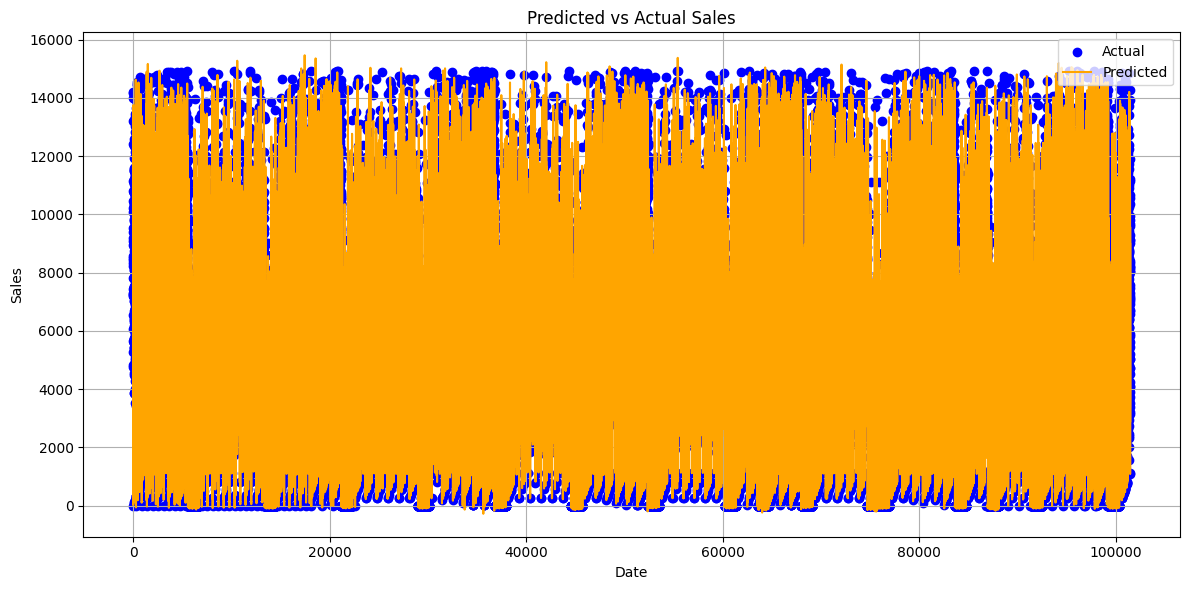

In [38]:
plt.figure(figsize=(12, 6))
# Plot the test data as dots
plt.scatter(test_df.index, test_df['Sales'], label="Actual", color="blue", marker='o')
# Plot the predictions as a line
plt.plot(pred_series.index, pred_series, label="Predicted", color="orange")

plt.title("Predicted vs Actual Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Trying ExponentialSmoothing Model

In [61]:
model_expo = ExponentialSmoothing(
    train_df['Sales'],
    trend='add',               # or 'mul' for multiplicative trend
    seasonal='add',            # or 'mul' or None
    seasonal_periods=5        # assuming weekly seasonality
).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [62]:
test_df.index = pd.to_datetime(test_df.index)

# Number of steps to forecast
n_test = len(test_df)

# Generate predictions
expo_forecast = model_expo.forecast(steps=n_test)

# Optional: Add to test_df for comparison
test_df['Expo_Prediction'] = expo_forecast.values

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
y_true = test_df['Sales']
y_pred = test_df['Expo_Prediction']

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Error (MAE): 25753.93
Mean Squared Error (MSE): 808758672.42
Root Mean Squared Error (RMSE): 28438.68


### Try different parameters to determine the best for sarima model

In [ ]:
# Dictionary to store results
results = {}

# Loop to try different seasonal periods
for m in [7, 30, 365]:
    print(f"\nTrying seasonal period m={m}")
    model = auto_arima(train_df['Sales'], seasonal=True, m=m, stepwise=True, trace=True,
                       suppress_warnings=True)

    # Store the results in a dictionary
    results[m] = {
        'AIC': model.aic(),
        'BIC': model.bic(),
        'RMSE': model.resid().std()  # You can compute RMSE from residuals
    }

# Print out the results to compare
for m, metrics in results.items():
    print(f"\nResults for m={m}:")
    print(f"AIC: {metrics['AIC']}")
    print(f"BIC: {metrics['BIC']}")
    print(f"RMSE: {metrics['RMSE']}")



Trying seasonal period m=7
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1597.40 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=15137598.030, Time=19.44 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=14915586.685, Time=129.43 sec


#### The run crashed due to ram

In [ ]:
# Assuming you have your sales data in train_df['Sales']
model = SARIMAX(train_df['Sales'],
                order=(9, 0, 36),            # (p, d, q) for non-seasonal part
                seasonal_order=(1, 0, 1, 365),  # (P, D, Q, s) for seasonal part (s=31)
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the model
results = model.fit()

# Print the summary of the model
print(results.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [ ]:
predictions = results.predict(start=test_df.index[0], end=test_df.index[-1])


In [ ]:
# Calculate MSE and RMSE
mse = mean_squared_error(test_df['Sales'], predictions)
rmse = np.sqrt(mse)

# Print MSE and RMSE
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')# Calculate MSE and RMSE
mse = mean_squared_error(test_df['Sales'], predictions)
rmse = np.sqrt(mse)

# Print MSE and RMSE
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

In [ ]:
# Plot the actual test data vs predictions
plt.figure(figsize=(10, 6))
plt.plot(test_df.index, test_df['Sales'], label='Actual Sales', color='blue', linestyle='-', linewidth=2)
plt.plot(test_df.index, predictions, label='Predicted Sales', color='red', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [ ]:
def auto_corr(sales):
    lag_acf = acf(sales, nlags=100)
    lag_pacf = pacf(sales, nlags=100, method='ols')

    # Find where ACF/PACF first touch or get very close to zero (excluding lag 0)
    def first_near_zero(arr, tol=0.05):
        for i in range(1, len(arr)):
            if abs(arr[i]) < tol:
                return i
        return None

    p = first_near_zero(lag_pacf)
    q = first_near_zero(lag_acf)

    print(f"Suggested AR (p) from PACF: {p}")
    print(f"Suggested MA (q) from ACF: {q}")

    # Plot
    plt.figure(figsize=(12,5))
    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0, linestyle='--', color='red')
    plt.axvline(x=0, linestyle='--', color='gray')
    plt.axhline(y=1.96/np.sqrt(len(sales)), linestyle='--', color='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales)), linestyle='--', color='red')
    plt.title('ACF')

    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0, linestyle='--', color='red')
    plt.axvline(x=0, linestyle='--', color='gray')
    plt.axhline(y=1.96/np.sqrt(len(sales)), linestyle='--', color='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales)), linestyle='--', color='red')
    plt.title('PACF')

    plt.tight_layout()
    plt.show()


Suggested AR (p) from PACF: 9
Suggested MA (q) from ACF: 36


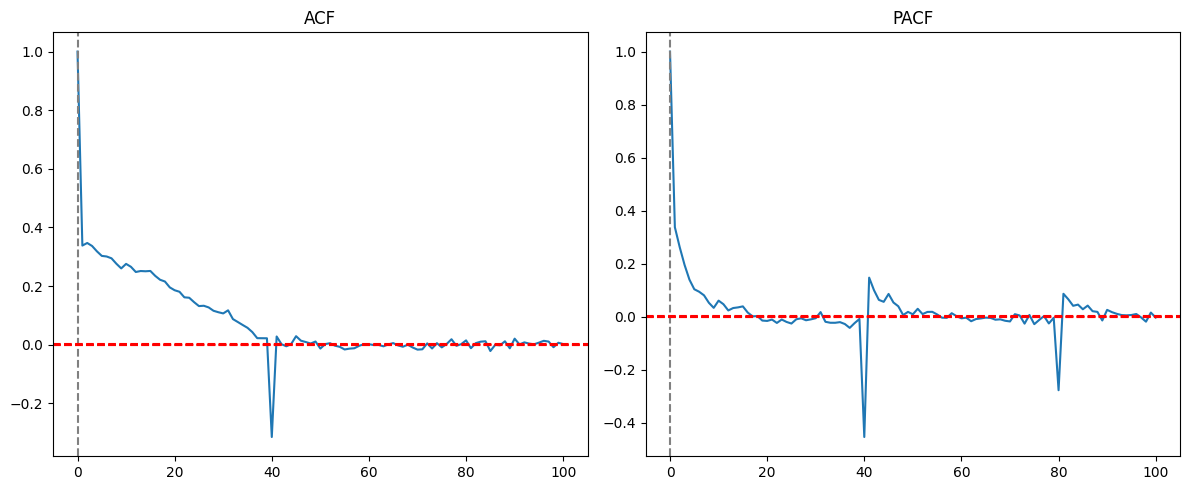

In [ ]:
auto_corr(y_diff)


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])  # Ensure the date column is in datetime format
df.set_index('Date', inplace=True)       # Set it as the index


### Second test stationary rolling mean

In [ ]:
def rolling_mean_test(time_series):
    rolling_mean=time_series.rolling(window=7).mean()
    rolling_std=time_series.rolling(window=7).std()
    plt.figure(figsize=(15,8))
    orig = plt.plot(time_series.resample('W').mean(), color='blue',label='Original')
    mean = plt.plot(rolling_mean.resample('W').mean(), color='red', label='Rolling Mean')
    std = plt.plot(rolling_std.resample('W').mean(), color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.show(block=False)

In [ ]:
rolling_mean_test(df['Sales'])


### the time series is stationary so we dont have to do difference

In [ ]:
# df['Sales_Diff'] = df['Sales_Log'].diff().dropna()
# adf_test(df['Sales_Diff'].dropna())

# # Plot Differenced Data
# plt.figure(figsize=(12,6))
# plt.plot(df['Sales_Diff'], label='Differenced Sales')
# plt.legend()
# plt.show()


In [ ]:
# adf_test(df['Sales_Log'])

In [ ]:
df['rolling_mean'] = df['Sales'].rolling(window=3).mean()
df['rolling_std'] = df['Sales'].rolling(window=3).std()


In [ ]:
acf_values = acf(df['Sales'], nlags=40)
if np.all(np.abs(acf_values) < 0.1):  # ACF close to 0 means white noise
    print("The series appears to be white noise (random).")
else:
    print('not white noise')

not white noise


### check the trend and seasonality in our data.

In [ ]:

def plot_timeseries(df, store_type):
    sales = df[df['Store'] == store_type]['Sales']

    fig, axes = plt.subplots(3, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    decomposition = seasonal_decompose(sales.dropna(), model='additive', period=360)

    estimated_trend = decomposition.trend
    estimated_seasonal = decomposition.seasonal
    estimated_residual = decomposition.resid

    axes[0].plot(estimated_trend, label='Trend', color='blue')
    axes[0].legend(loc='upper left')

    axes[1].plot(estimated_seasonal, label='Seasonality', color='green')
    axes[1].legend(loc='upper left')

    axes[2].plot(estimated_residual, label='Residuals', color='red')
    axes[2].legend(loc='upper left')

    plt.title(f'Time Series Decomposition for Store Type: {store_type}')
    plt.show()



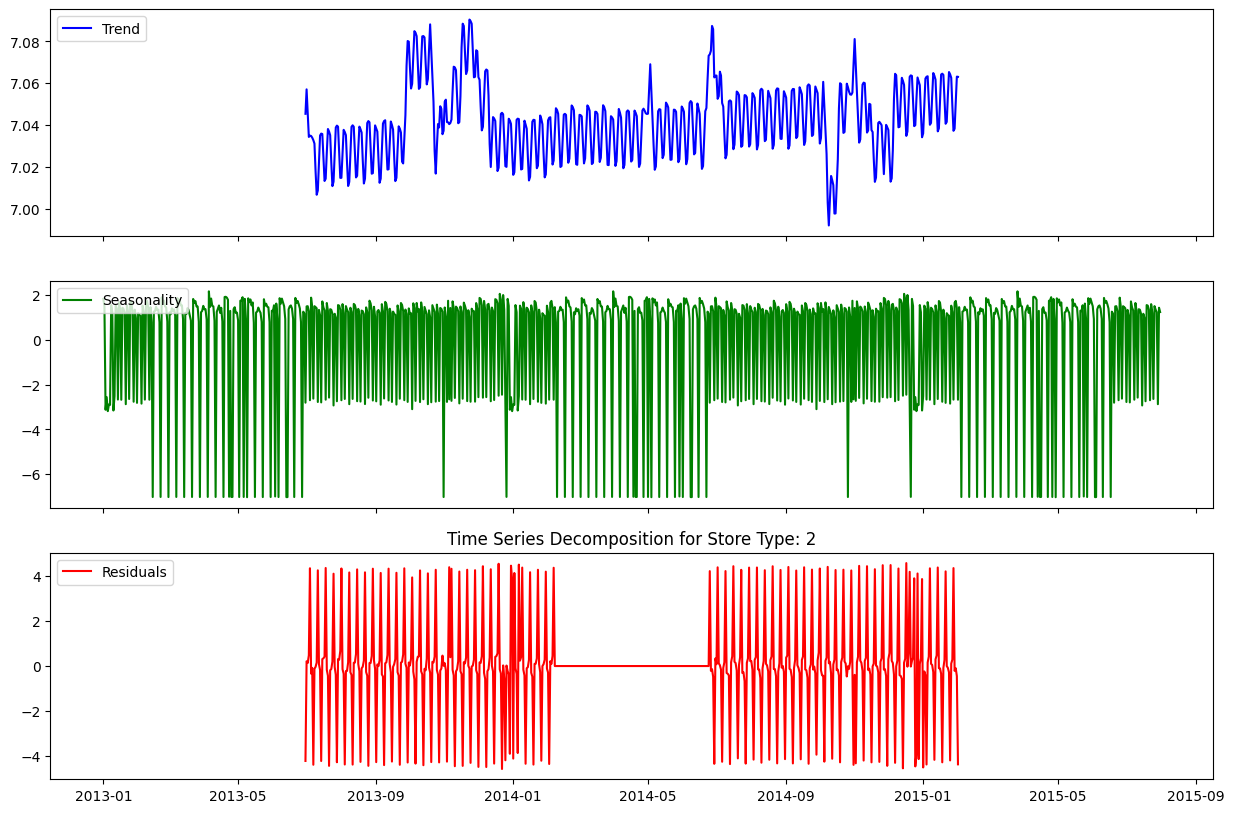

In [ ]:
plot_timeseries(df,2)

**aggregating data to weekly instead of daily** before using predictive models is generally a **good approach**, especially if:  

✅ **Daily fluctuations add noise** (e.g., promotions, weather changes, or holidays).  
✅ **The business operates on a weekly cycle** (e.g., weekly restocking, payroll cycles, customer patterns).  
✅ **You need lower computational cost** (especially with large datasets).

# Prophet Model
# Data Preparing for Prophet Model

Load Dataset

In [5]:
def load_prophet_data():
    # Data for Prophet forecasting – note this may be a different CSV file
    # Update the DATA_PATH as necessary
    DATA_PATH = r'D:\Courses\Data Science - Depi\Final Project\rossmann-store-sales\rossman.csv'
    data = pd.read_csv(DATA_PATH, usecols=lambda col: col != "Unnamed: 0",index_col=['Date'])
    return data
data = load_prophet_data()

Checking Sales and Range of Customers per each store and assortment

In [6]:
# StoreType:

#     a: Represents the standard, typically larger, full‑service store with a broad customer base.

#     b: Denotes a medium‑sized store with a more specialized or localized layout.

#     c: Indicates a smaller format store with a limited physical footprint.

#     d: Often reflects a store with unique layout or design characteristics that differentiate it from the other types.

# Assortment:

#     a: Basic assortment, offering a limited but standard range of products.

#     b: Extra assortment with a moderately expanded product range compared to basic.

#     c: Extended assortment, featuring a wide variety of products to cater to diverse customer needs.

store_type_map = {'a': 'Large Stores','b': 'Medium Stores', 'c':'Small Stores' , 'd': 'X Small Stores'}
data["StoreType"] = data["StoreType"].replace(store_type_map)

assortment_type_map = {'a': 'Basic Selection Items','b': 'Extended Selection Items', 'c':' Full Selection'}
data["Assortment"] = data["Assortment"].replace(assortment_type_map)

sales_per_store_assortment = data.groupby(['StoreType', 'Assortment'])[['Customers','Sales']].sum().reset_index()
sales_per_store_assortment = sales_per_store_assortment.sort_values(by=['Sales','Customers'],ascending=False)

print(sales_per_store_assortment)

        StoreType                Assortment  Customers       Sales
1    Large Stores     Basic Selection Items  217184233  1870105131
0    Large Stores            Full Selection  146357201  1295229728
7  X Small Stores            Full Selection  102073633  1161366186
8  X Small Stores     Basic Selection Items   54831362   604026757
6    Small Stores     Basic Selection Items   49183207   400260421
5    Small Stores            Full Selection   42946498   382961005
3   Medium Stores     Basic Selection Items   11568136    71357761
4   Medium Stores  Extended Selection Items   16972525    70946312
2   Medium Stores            Full Selection    2924960    16927322


Using Label Encoder to encode object data

In [7]:

store_type_map = {'a': 4,'b': 3, 'c':2 , 'd': 1}
data["StoreType"] = data["StoreType"].replace(store_type_map)

assortment_type_map = {'a': 1,'b': 2, 'c':3}
data["Assortment"] = data["Assortment"].replace(assortment_type_map)

encoder = LabelEncoder()
rossman_object = data.select_dtypes("object")
# print(rossman_object)
encoded_data = rossman_object.apply(encoder.fit_transform)
encoded_df = pd.DataFrame(encoded_data, columns=rossman_object.columns)

# Correct `data` reassignment
data = data.drop(columns=rossman_object.columns)  # Ensure it's a DataFrame
data = pd.concat([data, encoded_df], axis=1)
data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,...,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,Month,WeekOfYear,DayOfYear,StoreType,Assortment,PromoInterval
Date,,,,,,,,,,,,,,,,,,,,,
7/31/2015,1,5,5263,555,1,1,0,1,1270,9,...,0,0,0,2015,7,31,212,2,1,0
7/31/2015,2,5,6064,625,1,1,0,1,570,11,...,1,13,2010,2015,7,31,212,0,1,2
7/31/2015,3,5,8314,821,1,1,0,1,14130,12,...,1,14,2011,2015,7,31,212,0,1,2
7/31/2015,4,5,13995,1498,1,1,0,1,620,9,...,0,0,0,2015,7,31,212,2,0,0
7/31/2015,5,5,4822,559,1,1,0,1,29910,4,...,0,0,0,2015,7,31,212,0,1,0


# Finding Most Impact Indepdent Variables that Impact Sales

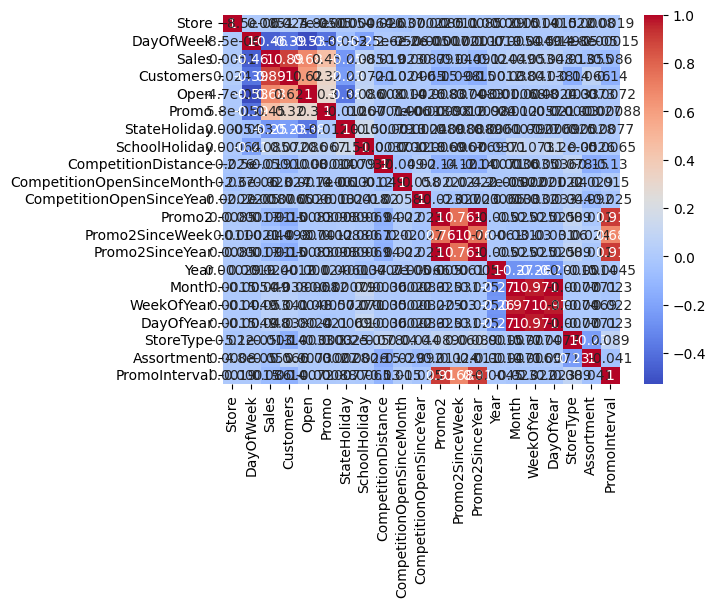

In [8]:
sns.heatmap(data.corr(), annot=True, cmap="coolwarm")
plt.show()

Unstack correlation matrix and filter out self-correlations

In [9]:
corr_matrix = data.corr()
high_corr_pairs = corr_matrix.unstack().sort_values(ascending=False)
high_corr_pairs = high_corr_pairs[high_corr_pairs != 1]
high_corr_pairs

Promo2           Promo2SinceYear    0.999999
Promo2SinceYear  Promo2             0.999999
DayOfYear        Month              0.996247
Month            DayOfYear          0.996247
WeekOfYear       DayOfYear          0.968353
                                      ...   
Promo            DayOfWeek         -0.392925
DayOfWeek        Sales             -0.462125
Sales            DayOfWeek         -0.462125
DayOfWeek        Open              -0.528963
Open             DayOfWeek         -0.528963
Length: 420, dtype: float64

Drop Multicolinearity Columns

In [10]:
threshold = 0.7

# List of important columns to keep
Target = ['Sales','Store']

# Separate important columns
important_data = data[Target]  # Store them separately
data_for_corr = data.drop(columns=Target, errors='ignore')  # Exclude them before correlation

# Compute the correlation matrix
corr_matrix = data_for_corr.corr().abs()

# Find columns that are highly correlated
correlated_features = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):  # Avoid duplicate pairs
        if corr_matrix.iloc[i, j] > threshold:  
            colname = corr_matrix.columns[j]  # Pick the second column
            correlated_features.add(colname)  # Add to drop list

print("Columns to drop:", correlated_features)

# Drop highly correlated features
data_cleaned = data_for_corr.drop(columns=correlated_features, errors='ignore')
data_cleaned.head()

Columns to drop: {'Promo2SinceWeek', 'WeekOfYear', 'PromoInterval', 'Promo2SinceYear', 'DayOfYear'}


,DayOfWeek,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Year,Month,StoreType,Assortment
Date,,,,,,,,,,,,,,
7/31/2015,5,555,1,1,0,1,1270,9,2008,0,2015,7,2,1
7/31/2015,5,625,1,1,0,1,570,11,2007,1,2015,7,0,1
7/31/2015,5,821,1,1,0,1,14130,12,2006,1,2015,7,0,1
7/31/2015,5,1498,1,1,0,1,620,9,2009,0,2015,7,2,0
7/31/2015,5,559,1,1,0,1,29910,4,2015,0,2015,7,0,1


In [11]:
print("Final dataset shape:", data_cleaned.shape)
print("Remaining columns:", data_cleaned.columns)

Final dataset shape: (1017209, 14)
Remaining columns: Index(['DayOfWeek', 'Customers', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Year', 'Month', 'StoreType',
       'Assortment'],
      dtype='object')


In [12]:
print(data_cleaned.dtypes)

DayOfWeek                    int64
Customers                    int64
Open                         int64
Promo                        int64
StateHoliday                 int64
SchoolHoliday                int64
CompetitionDistance          int64
CompetitionOpenSinceMonth    int64
CompetitionOpenSinceYear     int64
Promo2                       int64
Year                         int64
Month                        int64
StoreType                    int32
Assortment                   int32
dtype: object


Using variance_inflation_factor to continue dropping multicolinearity columns

In [13]:
# VIF DataFrame
vif_data = pd.DataFrame()
vif_data["feature"] = data_cleaned.columns
vif_data["VIF"] = [variance_inflation_factor(data_cleaned.values, i) for i in range(data_cleaned.shape[1])]

# Print VIF values
print("\nVariance Inflation Factors (VIF):")
print(vif_data)


Variance Inflation Factors (VIF):
                      feature            VIF
0                   DayOfWeek       8.550945
1                   Customers       5.241468
2                        Open      13.952880
3                       Promo       1.994287
4                StateHoliday       1.374614
5               SchoolHoliday       1.314867
6         CompetitionDistance       1.611427
7   CompetitionOpenSinceMonth       8.937526
8    CompetitionOpenSinceYear  140760.955325
9                      Promo2       2.148512
10                       Year  140683.979138
11                      Month       4.154926
12                  StoreType       1.946610
13                 Assortment       2.303413


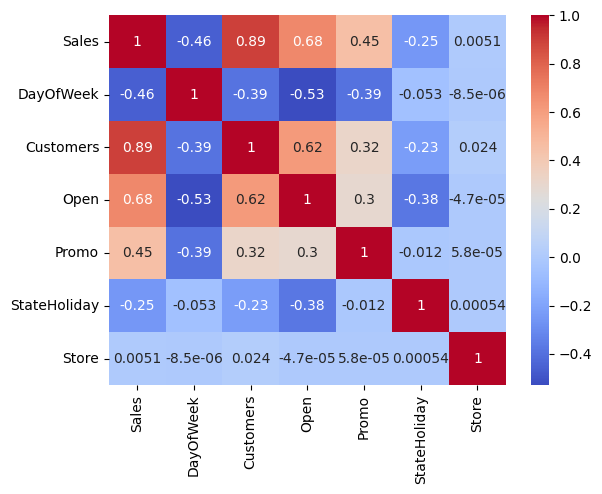

In [14]:
Final_Data=data_cleaned.drop(columns=['CompetitionOpenSinceYear','Year'])

# Re-add `Sales` to the final dataset
rossman_cleaned = pd.concat([important_data, Final_Data], axis=1)
# print(rossman_cleaned.head())

# Calculate the correlation matrix
corr_matrix = rossman_cleaned.corr()


target_column = 'Sales'  
threshold = 0.1  

# Get the correlation of each feature with the target variable
target_corr = corr_matrix[target_column].abs()

# Select features with correlation greater than the threshold
features_to_keep = target_corr[target_corr > threshold].index.tolist()
# print(features_to_keep)
features_to_keep.append("Store")
features_to_keep
# Create a new dataframe with only relevant features
retail_data_filtered = rossman_cleaned[features_to_keep]

sns.heatmap(retail_data_filtered.corr(), annot=True, cmap="coolwarm")
plt.show()

# Prophet Model

In [15]:
# Reset Data to return Date as column
Data_Prophet = retail_data_filtered.reset_index()

#Changin Date to Datetime format
Data_Prophet['Date'] = pd.to_datetime(Data_Prophet['Date'])

# Rename the columns
Data_Prophet = Data_Prophet.rename(columns={'Date': 'ds', 'Sales': 'y'})

print(Data_Prophet.head())


          ds      y  DayOfWeek  Customers  Open  Promo  StateHoliday  Store
0 2015-07-31   5263          5        555     1      1             0      1
1 2015-07-31   6064          5        625     1      1             0      2
2 2015-07-31   8314          5        821     1      1             0      3
3 2015-07-31  13995          5       1498     1      1             0      4
4 2015-07-31   4822          5        559     1      1             0      5


In [16]:
# Filtering on Store
Data_Prophet = Data_Prophet[Data_Prophet['Store'] == 1].sort_values(by='ds', ascending=True).copy()

###### Step 4: Train Test Split
# Train test split
split_date_recent = Data_Prophet['ds'].max() - pd.DateOffset(months=6)
# Train test split
train = Data_Prophet[Data_Prophet['ds'] < split_date_recent].copy()
test = Data_Prophet[Data_Prophet['ds'] >= split_date_recent].copy()

In [17]:
# Check the shape of the dataset
print(train.shape)
print(test.shape)


(760, 8)
(182, 8)


# Baseline Model

22:40:47 - cmdstanpy - INFO - Chain [1] start processing
22:40:48 - cmdstanpy - INFO - Chain [1] done processing


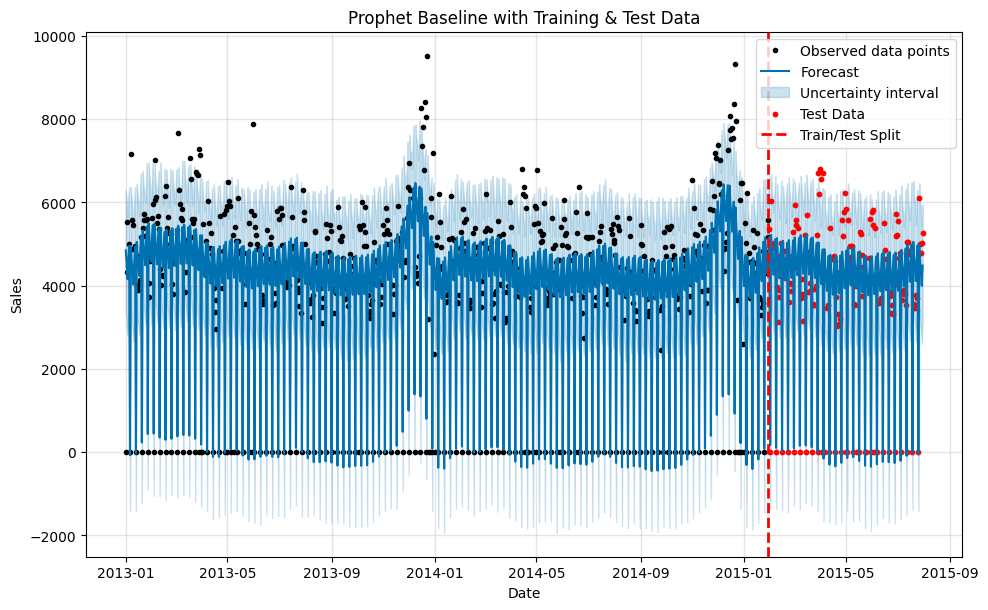

Mean Absolute Error (MAE): 714.49
Mean Squared Error (MSE): 1216157.44
Root Mean Squared Error (RMSE): 1102.80


In [18]:

# Model Baseline
model_baseline = Prophet()

# Fit the model on the training dataset
model_baseline.fit(train)

# Create the time range for the forecast
future_baseline = model_baseline.make_future_dataframe(periods=len(test))

# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)

# Visualize the forecast
# 1. Plot the Prophet forecast
fig = model_baseline.plot(forecast_baseline, xlabel='Date', ylabel='Sales')
ax = fig.gca()  # Get the current axes from the figure


# 2. Overlay the test data
test_plot = ax.scatter(test['ds'], test['y'], color='red', label='Test Data', s=10)

# 3. Add a vertical line to indicate the train/test split
split_date = train['ds'].max()  # or use test['ds'].min() if you prefer
ax.axvline(x=split_date, color='red', linestyle='--', linewidth=2, label='Train/Test Split')

# 4. Create a combined legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='best')

plt.title("Prophet Baseline with Training & Test Data")
plt.show()


# Merge actual and predicted values
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-len(test):], on='ds')

# Check MAE value
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming performance_baseline is a DataFrame with actual values ('y') and predictions ('yhat')
performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MSE = mean_squared_error(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_RMSE = np.sqrt(performance_baseline_MSE)

print(f"Mean Absolute Error (MAE): {performance_baseline_MAE:.2f}")
print(f"Mean Squared Error (MSE): {performance_baseline_MSE:.2f}")
print(f"Root Mean Squared Error (RMSE): {performance_baseline_RMSE:.2f}")



# Multivariate Model

22:40:57 - cmdstanpy - INFO - Chain [1] start processing
22:40:58 - cmdstanpy - INFO - Chain [1] done processing


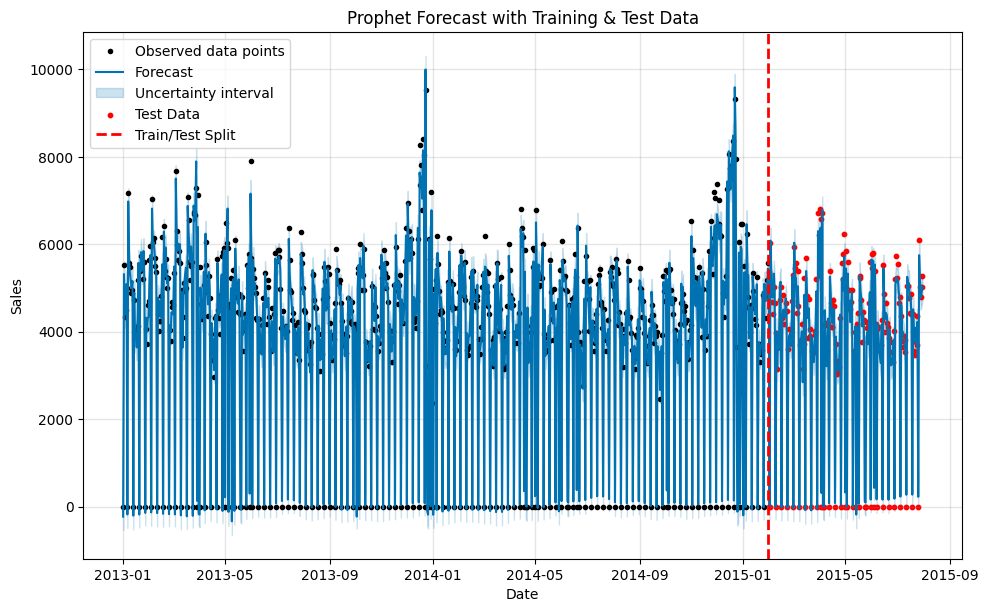

Mean Absolute Error (MAE): 189.55
Mean Squared Error (MSE): 59010.20
Root Mean Squared Error (RMSE): 242.92


In [19]:
###### Multivariate Model

# Add seasonality
holiday_df_recent = Data_Prophet[Data_Prophet['StateHoliday'] == 1][['ds']].drop_duplicates().copy()
holiday_df_recent['holiday'] = 'state_holiday'

model_multivariate = Prophet(yearly_seasonality=True, holidays=holiday_df_recent)
# Add regressor
model_multivariate.add_regressor('Customers')
model_multivariate.add_regressor('Promo')
model_multivariate.add_regressor('Open')
model_multivariate.add_regressor('DayOfWeek')

# Fit the model on the training dataset
model_multivariate.fit(train)

# Create the time range for the forecast
future_multivariate = model_multivariate.make_future_dataframe(periods=len(test))

# Append the regressor values
future_multivariate = pd.merge(future_multivariate, Data_Prophet[['ds', 'Customers', 'Promo', 'Open', 'Store', 'DayOfWeek']], on='ds', how='inner')

# Make prediction
forecast_multivariate = model_multivariate.predict(future_multivariate)

performance_multivariate = pd.merge(test, forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-len(test):], on='ds')

# 1. Plot the Prophet forecast
fig = model_multivariate.plot(forecast_multivariate, xlabel='Date', ylabel='Sales')
ax = fig.gca()  # Get the current axes from the figure

# 2. Overlay the test data
test_plot = ax.scatter(test['ds'], test['y'], color='red', label='Test Data', s=10)

# 3. Add a vertical line to indicate the train/test split
split_date = train['ds'].max()  # or use test['ds'].min() if you prefer
ax.axvline(x=split_date, color='red', linestyle='--', linewidth=2, label='Train/Test Split')

# 4. Create a combined legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='best')

plt.title("Prophet Forecast with Training & Test Data")
plt.show()

# Assuming performance_baseline is a DataFrame with actual values ('y') and predictions ('yhat')
performance_multivariate_MAE = mean_absolute_error(performance_multivariate['y'], performance_multivariate['yhat'])
performance_multivariate_baseline_MSE = mean_squared_error(performance_multivariate['y'], performance_multivariate['yhat'])
performance_multivariate_baseline_RMSE = np.sqrt(performance_multivariate_baseline_MSE)

print(f"Mean Absolute Error (MAE): {performance_multivariate_MAE:.2f}")
print(f"Mean Squared Error (MSE): {performance_multivariate_baseline_MSE:.2f}")
print(f"Root Mean Squared Error (RMSE): {performance_multivariate_baseline_RMSE:.2f}")
